In [1]:
import re
import unicodedata

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from adjustText import adjust_text
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from scipy.spatial.distance import cdist
from scipy.stats import ttest_ind, zscore

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

pd.set_option('display.max_rows', None)

In [2]:
DATA_DIR = './Leagues'

## 포지션별 스탯
STATS_PER_POSITION = {
    'Goalkeeper' : ['Total_Saves', 'SixYardBox_Saves', 'PenaltyArea_Saves', 'OutOfBox_Saves', 'age'],
 

    'Centre-Back' : [
        'age',
        'TotalTackles', 'DribbledPast', 'TotalAttemptedTackles', 
        'Total_Interception', 
        'Fouls', 
        'Total_Interception', 
        'Total_Clearances',
        'ShotsBlocked', 'CrossesBlocked', 'PassesBlocked',
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Crosses_per_game', 'Corner', 'Throughball'
        ],


    'Right-Back' : [
        'age',
        'TotalTackles', 'DribbledPast', 'TotalAttemptedTackles', 
        'Total_Interception', 
        'Fouls', 
        'Total_Interception', 
        'Total_Clearances',
        'ShotsBlocked', 'CrossesBlocked', 'PassesBlocked',
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Crosses_per_game', 'Corner', 'Throughball'
        ],


    'Left-Back' : [
        'age',
        'TotalTackles', 'DribbledPast', 'TotalAttemptedTackles', 
        'Total_Interception', 
        'Fouls', 
        'Total_Interception', 
        'Total_Clearances',
        'ShotsBlocked', 'CrossesBlocked', 'PassesBlocked',
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Crosses_per_game', 'Corner', 'Throughball'
        ],

    'Left Winger' : [
        'age',
        'TotalTackles', 'DribbledPast', 'TotalAttemptedTackles', 
        'Total_Interception', 
        'Fouls', 'Fouled', 
        'Total_Interception', 
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Crosses_per_game', 'Corner', 'Throughball', 'Freekick',
        'Unsuccessful_Dribbles', 'Successful_Dribbles',
        'UnsuccessfulTouches', 'Dispossessed',
        'xG', 'xGPerNinety', 
        # 'totalShots',
        ],


    'Right Winger' : [
        'age',
        'TotalTackles', 'DribbledPast', 'TotalAttemptedTackles', 
        'Total_Interception', 
        'Fouls', 'Fouled', 
        'Total_Interception', 
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Crosses_per_game', 'Corner', 'Throughball', 'Freekick',
        'Unsuccessful_Dribbles', 'Successful_Dribbles',
        'UnsuccessfulTouches', 'Dispossessed',
        'xG', 'xGPerNinety', 
        # 'totalShots',
        ],


    'Central Midfield' : [
        'age',
        'TotalTackles', 'DribbledPast', 'TotalAttemptedTackles', 
        'Total_Interception', 
        'Fouls', 'Fouled', 
        'Total_Interception', 
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Corner', 'Throughball', 'Freekick',
        'Unsuccessful_Dribbles', 'Successful_Dribbles',
        'UnsuccessfulTouches', 'Dispossessed',
        'xG', 'xGPerNinety', 
        # 'totalShots',
        ],


    'Left Midfield' : [
        'age',
        'TotalTackles', 'DribbledPast', 'TotalAttemptedTackles', 
        'Total_Interception', 
        'Fouls', 'Fouled', 
        'Total_Interception', 
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Corner', 'Throughball', 'Freekick',
        'Unsuccessful_Dribbles', 'Successful_Dribbles',
        'UnsuccessfulTouches', 'Dispossessed',
        'xG', 'xGPerNinety', 
        # 'totalShots',
        ],


    'Right Midfield' : [
        'age',
        'TotalTackles', 'DribbledPast', 'TotalAttemptedTackles', 
        'Total_Interception', 
        'Fouls', 'Fouled', 
        'Total_Interception', 
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Corner', 'Throughball', 'Freekick',
        'Unsuccessful_Dribbles', 'Successful_Dribbles',
        'UnsuccessfulTouches', 'Dispossessed',
        'xG', 'xGPerNinety', 
        # 'totalShots',
        ],


    'Defensive Midfield' : [
        'age',
        'TotalTackles', 'DribbledPast', 'TotalAttemptedTackles', 
        'Total_Interception', 
        'Fouls', 'Fouled', 
        'Total_Interception', 
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Corner', 'Throughball', 'Freekick',
        'Unsuccessful_Dribbles', 'Successful_Dribbles',
        'UnsuccessfulTouches', 'Dispossessed',
        'xG', 'xGPerNinety', 
        # 'totalShots',
        ],


    'Attacking Midfield' : [
        'age',
        'Total_Interception', 
        'Fouls', 'Fouled', 
        'Total_Interception', 
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        'Corner', 'Throughball', 'Freekick',
        'Unsuccessful_Dribbles', 'Successful_Dribbles',
        'UnsuccessfulTouches', 'Dispossessed',
        'xG', 'xGPerNinety', 
        # 'totalShots',
        ],


    'Centre-Forward' : [
        'age',
        'Fouled', 
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        # 'Corner', 'Throughball', 'Freekick',
        'Unsuccessful_Dribbles', 'Successful_Dribbles',
        'UnsuccessfulTouches', 'Dispossessed',
        'xG', 'xGPerNinety', 
        # 'totalShots',
        ],


    'Second Striker' : [
        'age',
        'Fouled', 
        'Yel', 'Red', 'AerialsWon',
        'AccLB', 'AccSP',
        'Longpass_per_game', 'Shortpass_per_game',
        # 'Corner', 'Throughball', 'Freekick',
        'Unsuccessful_Dribbles', 'Successful_Dribbles',
        'UnsuccessfulTouches', 'Dispossessed',
        'xG', 'xGPerNinety', 
        # 'totalShots',
        ],
}


In [3]:
players_stats = pd.read_csv(f'{DATA_DIR}/all_players_stats.csv', encoding='utf-8')
players_values = pd.read_csv(f'{DATA_DIR}/all_players_values.csv', encoding='utf-8')
players_details = pd.read_csv(f'{DATA_DIR}/all_players_stats_details.csv', encoding='utf-8')

teams_stats = pd.read_csv(f'{DATA_DIR}/all_teams_stats.csv', encoding='utf-8')
teams_values = pd.read_csv(f'{DATA_DIR}/all_teams_values.csv', encoding='utf-8')

In [4]:
def convert_market_value(value):
    if pd.isna(value):
        return None
    value = value.replace('€', '').strip().lower()
    if 'm' in value:
        return float(value.replace('m', '')) * 1_000_000
    elif 'k' in value:
        return float(value.replace('k', '')) * 1_000
    try:
        return float(value)
    except ValueError:
        return None

players_values['Market Value'] = players_values['Market Value'].apply(convert_market_value)

In [5]:
players_details_reduced = players_details.drop(columns=['player_name', 'team_name'])
players_totals = players_stats.merge(players_details_reduced, left_index=True, right_index=True, how='left')

players_values_reduced = players_values.drop(columns=['Team', 'Position', 'Date of Birth', 'Age', 'Nationality'])
players_values_reduced.rename(columns={'Name': 'player_name'}, inplace=True)
players_totals = players_totals.merge(players_values_reduced, on='player_name', how='left')

players_totals.rename(columns={
    'Red_x': 'Red', 
    'Fouls_y' : 'Fouls', 
    'Yellow' : 'Yel_x',
    'Short' : 'Shortpass_per_game',
    'Unsuccessful' : 'Unsuccessful_Dribbles',
    'Successful' : 'Successful_Dribbles'
}, inplace=True)
players_totals = players_totals[[col for col in players_totals.columns if not col.endswith('_x') and not col.endswith('_y')]]

players_totals['team_name'] = players_totals['team_name'].fillna('')
players_totals.drop_duplicates(subset=['player_name', 'team_name'], inplace=True)

# players_totals.to_csv('./Leagues/all_players_stats_total.csv', index=False)
# players_totals.head(10)

In [6]:
players_totals['position'].unique()

array(['Goalkeeper', 'Attacking Midfield', 'Centre-Forward', 'Right-Back',
       'Right Winger', 'Left Winger', 'Defensive Midfield',
       'Central Midfield', 'Centre-Back', 'Left-Back', 'Left Midfield',
       'Second Striker', 'Right Midfield'], dtype=object)

In [7]:
def group_top_teams_by_position(all_players_stats, all_teams_stats):
    all_teams_stats['Pts'] = pd.to_numeric(all_teams_stats['Pts'])
    top_teams = all_teams_stats.nlargest(15, 'Pts')['team_name'].tolist()
    
    top_teams_df = all_players_stats[
        (all_players_stats['team_name'].isin(top_teams)) &
        (all_players_stats['Apps'].apply(lambda x: int(x.split('(')[0]) if pd.notna(x) else 0) >= 15)
    ].copy()
    
    top_teams_df['positions'] = top_teams_df['position'].apply(lambda x: [pos.strip() for pos in x.split(',') if pd.notna(x)])
    all_positions = set(pos for positions in top_teams_df['positions'] for pos in positions)
    position_groups = {pos: [] for pos in all_positions}
    
    for _, row in top_teams_df.iterrows():
        player_name = row['player_name']
        player_positions = row['positions']
        
        for pos in player_positions:
            position_groups[pos].append(player_name)
    
    return position_groups, top_teams

top_position_groups, top_teams = group_top_teams_by_position(players_totals, teams_stats)

In [8]:
print(top_teams)
for position, players in top_position_groups.items():
    print(position, players)

['Napoli', 'Manchester City', 'Barcelona', 'Paris Saint-Germain', 'Arsenal', 'Lens', 'Real Madrid', 'Atletico Madrid', 'Manchester United', 'Lazio', 'Marseille', 'Inter', 'Newcastle', 'Bayern Munich', 'Borussia Dortmund']
Attacking Midfield ['Kevin De Bruyne', 'Bruno Fernandes', 'Martin Ødegaard', 'Bernardo Silva', 'Adrien Thomasson', 'David Pereira Da Costa', 'Jude Bellingham', 'Jamal Musiala', 'Julian Brandt', 'Thomas Lemar']
Centre-Forward ['Erling Haaland', 'Gabriel Jesus', 'Alexander Isak', 'Callum Wilson', 'Kylian Mbappé', 'Florian Sotoca', 'Alexis Sánchez', 'Loïs Openda', 'Sébastien Haller', 'Victor Osimhen', 'Lautaro Martínez', 'Romelu Lukaku', 'Ciro Immobile', 'Edin Dzeko', 'Antoine Griezmann', 'Karim Benzema', 'Robert Lewandowski', 'Álvaro Morata']
Central Midfield ['Joelinton', 'Ilkay Gündogan', 'Joe Willock', 'Christian Eriksen', 'Sean Longstaff', 'Seko Fofana', 'Valentin Rongier', 'Marco Verratti', 'Fabián Ruiz', 'Jordan Veretout', 'Vitinha', 'Mattéo Guendouzi', 'Leon Gore

In [9]:
def group_lower_teams_by_position_per_league(all_players_stats, all_teams_stats):
    all_teams_stats['Pts'] = pd.to_numeric(all_teams_stats['Pts'])
    excluded_teams_per_league = all_teams_stats.groupby('League').apply(lambda x: x.nlargest(3, 'Pts')['team_name']).tolist()

    position_groups = {}
    for league in all_teams_stats['League'].unique():
        lower_teams = all_teams_stats[
            (all_teams_stats['League'] == league) & (~all_teams_stats['team_name'].isin(excluded_teams_per_league))
        ]['team_name'].tolist()

        lower_teams_df = all_players_stats[
            (all_players_stats['team_name'].isin(lower_teams)) &
            (all_players_stats['Apps'].apply(lambda x: int(x.split('(')[0]) if pd.notna(x) else 0) >= 15)
        ]

        for _, row in lower_teams_df.iterrows():
            positions = [pos.strip() for pos in row['position'].split(',') if pd.notna(row['position'])]
            player_name = row['player_name']
            for pos in positions:
                if pos in position_groups:
                    position_groups[pos].append(player_name)
                else:
                    position_groups[pos] = [player_name]

    return position_groups

bottom_position_groups = group_lower_teams_by_position_per_league(players_totals, teams_stats)

In [10]:
position_groups = group_lower_teams_by_position_per_league(players_totals, teams_stats)

for position, players in position_groups.items():
    print(f"{position}: {players}")

Centre-Forward: ['Harry Kane', 'Ivan Toney', 'Aleksandar Mitrovic', 'Alexander Isak', 'Ollie Watkins', 'Callum Wilson', 'Jordan Ayew', 'Darwin Núñez', 'Dominic Solanke', 'Danny Welbeck', 'Rodrigo', 'Dominic Calvert-Lewin', 'Ché Adams', 'Taiwo Awoniyi', 'Michail Antonio', 'Odsonne Édouard', 'Patrick Bamford', 'Jamie Vardy', 'Diego Costa', 'Alexandre Lacazette', 'Terem Moffi', 'Jonathan David', 'Gaëtan Laborde', 'Steve Mounié', 'Wissam Ben Yedder', 'Habib Diallo', 'Terem Moffi', 'Karl Toko Ekambi', 'Folarin Balogun', 'Elye Wahi', 'Breel Embolo', 'Mama Baldé', 'Nuno Da Costa', 'Grejohn Kyei', 'Thijs Dallinga', 'Mostafa Mohamed', 'Arnaud Kalimuendo', 'Kevin Gameiro', 'Ignatius Ganago', 'Mounaïm El Idrissy', 'Evann Guessand', 'Ibrahima Koné', 'Ibrahima Niané', 'Adrien Hunou', 'Komnen Andric', "M'Baye Niang", 'Niclas Füllkrug', 'Randal Kolo Muani', 'Michael Gregoritsch', 'Marcus Thuram', 'Philipp Hofmann', 'Marvin Ducksch', 'Ludovic Ajorque', 'Sheraldo Becker', 'Lucas Höler', 'Kevin Behrens'

In [11]:
def find_similar_players(top_players_stats, bottom_players_stats, position, n=10):
    top_players_stats_filtered = top_players_stats[top_players_stats['player_name'].isin(top_position_groups[position])]
    bottom_players_stats_filtered = bottom_players_stats[bottom_players_stats['player_name'].isin(bottom_position_groups[position])]
    
    stat_columns = STATS_PER_POSITION[position]
    imputer = SimpleImputer(strategy='mean')
    # scaler = MinMaxScaler()
    
    top_players_stats_imputed = imputer.fit_transform(top_players_stats_filtered[stat_columns])
    # top_players_stats_scaled = scaler.fit_transform(top_players_stats_imputed)
    # top_players_avg_stats = top_players_stats_scaled.mean(axis=0).reshape(1, -1)
    top_players_avg_stats = top_players_stats_imputed.mean(axis=0).reshape(1, -1)
    
    
    bottom_players_stats_imputed = imputer.transform(bottom_players_stats_filtered[stat_columns])
    # bottom_players_stats_scaled = scaler.transform(bottom_players_stats_imputed)
    
    # similarity_scores = cosine_similarity(bottom_players_stats_scaled, top_players_avg_stats)
    similarity_scores = cosine_similarity(bottom_players_stats_imputed, top_players_avg_stats)
    most_similar_indices = similarity_scores.flatten().argsort()[::-1][:n]
    most_similar_players = bottom_players_stats_filtered.iloc[most_similar_indices]['player_name'].tolist()
    
    return most_similar_players


# def find_similar_players(top_players_stats, bottom_players_stats, position, n=10):
#     top_players_stats_filtered = top_players_stats[top_players_stats['player_name'].isin(top_position_groups[position])]
#     bottom_players_stats_filtered = bottom_players_stats[bottom_players_stats['player_name'].isin(bottom_position_groups[position])]
    
#     stat_columns = STATS_PER_POSITION[position]
#     imputer = SimpleImputer(strategy='mean')
#     scaler = RobustScaler()
    
#     top_players_stats_imputed = imputer.fit_transform(top_players_stats_filtered[stat_columns])
#     top_players_stats_scaled = scaler.fit_transform(top_players_stats_imputed)
#     top_players_avg_stats = top_players_stats_scaled.mean(axis=0).reshape(1, -1)
    
#     bottom_players_stats_imputed = imputer.transform(bottom_players_stats_filtered[stat_columns])
#     bottom_players_stats_scaled = scaler.transform(bottom_players_stats_imputed)
    
#     similarity_scores = cosine_similarity(bottom_players_stats_scaled, top_players_avg_stats)
#     most_similar_indices = similarity_scores.flatten().argsort()[::-1][:n]
#     most_similar_players = bottom_players_stats_filtered.iloc[most_similar_indices]['player_name'].tolist()
    
#     return most_similar_players

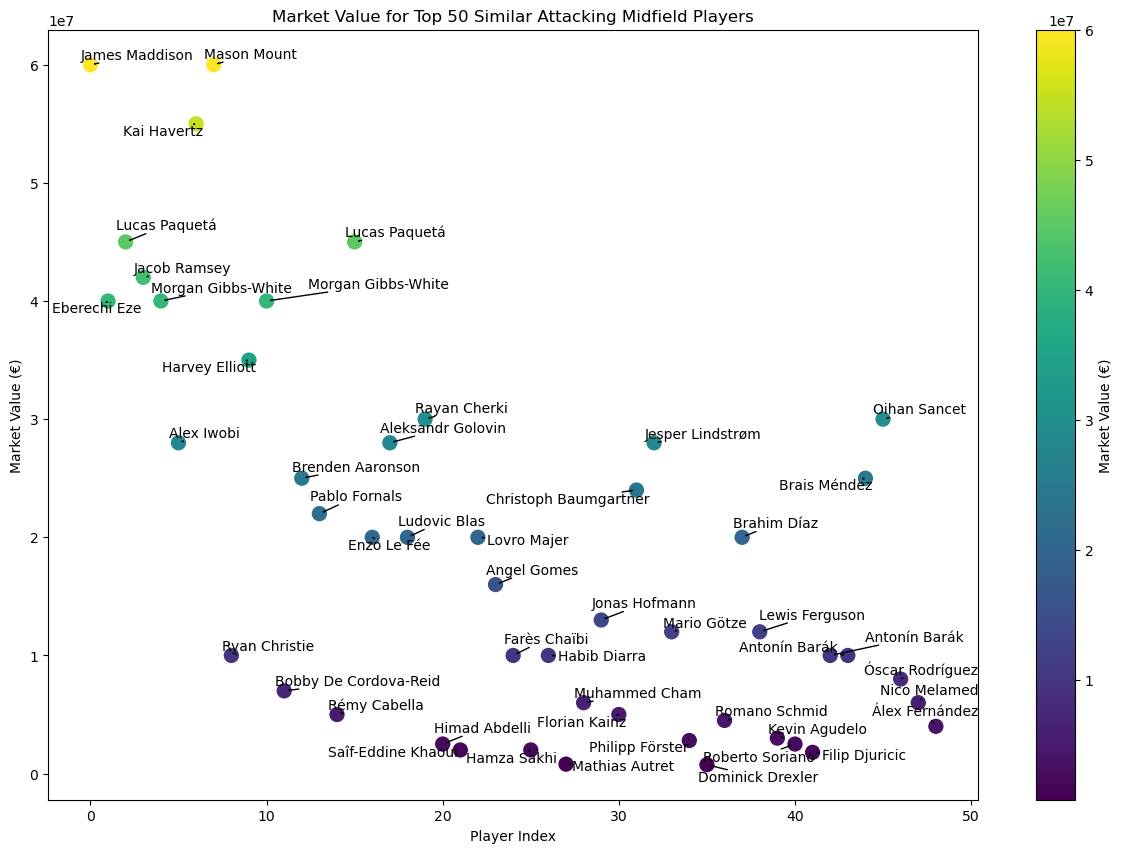

In [12]:
TARGET = 'Attacking Midfield'
N_MOST_SIMILAR_PLAYERS = 50

top_players_stats = players_totals[players_totals['team_name'].isin(top_teams)]
bottom_players_stats = players_totals[~players_totals['team_name'].isin(top_teams)]
most_similar_players = find_similar_players(top_players_stats, bottom_players_stats, TARGET, N_MOST_SIMILAR_PLAYERS)

top_players_stats_filtered = top_players_stats[top_players_stats['player_name'].isin(top_position_groups[TARGET])]
similar_players_stats = bottom_players_stats[bottom_players_stats['player_name'].isin(most_similar_players)]

plot_data = similar_players_stats[['player_name', 'Market Value']].copy()
plot_data['Market Value'] = pd.to_numeric(plot_data['Market Value'], errors='coerce')
plot_data.dropna(subset=['Market Value'], inplace=True)

norm = Normalize(vmin=plot_data['Market Value'].min(), vmax=plot_data['Market Value'].max())
cmap = plt.get_cmap('viridis')
sm = ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(15, 10))
scatter = plt.scatter(x=range(len(plot_data)), y=plot_data['Market Value'], s=100, c=plot_data['Market Value'].apply(lambda x: sm.to_rgba(x)))
plt.colorbar(sm, label='Market Value (€)')

texts = []
for i, txt in enumerate(plot_data['player_name']):
    texts.append(plt.text(i, plot_data['Market Value'].iloc[i], txt, ha='center'))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.xlabel('Player Index')
plt.ylabel('Market Value (€)')
plt.title(f'Market Value for Top {N_MOST_SIMILAR_PLAYERS} Similar {TARGET} Players')
plt.show()

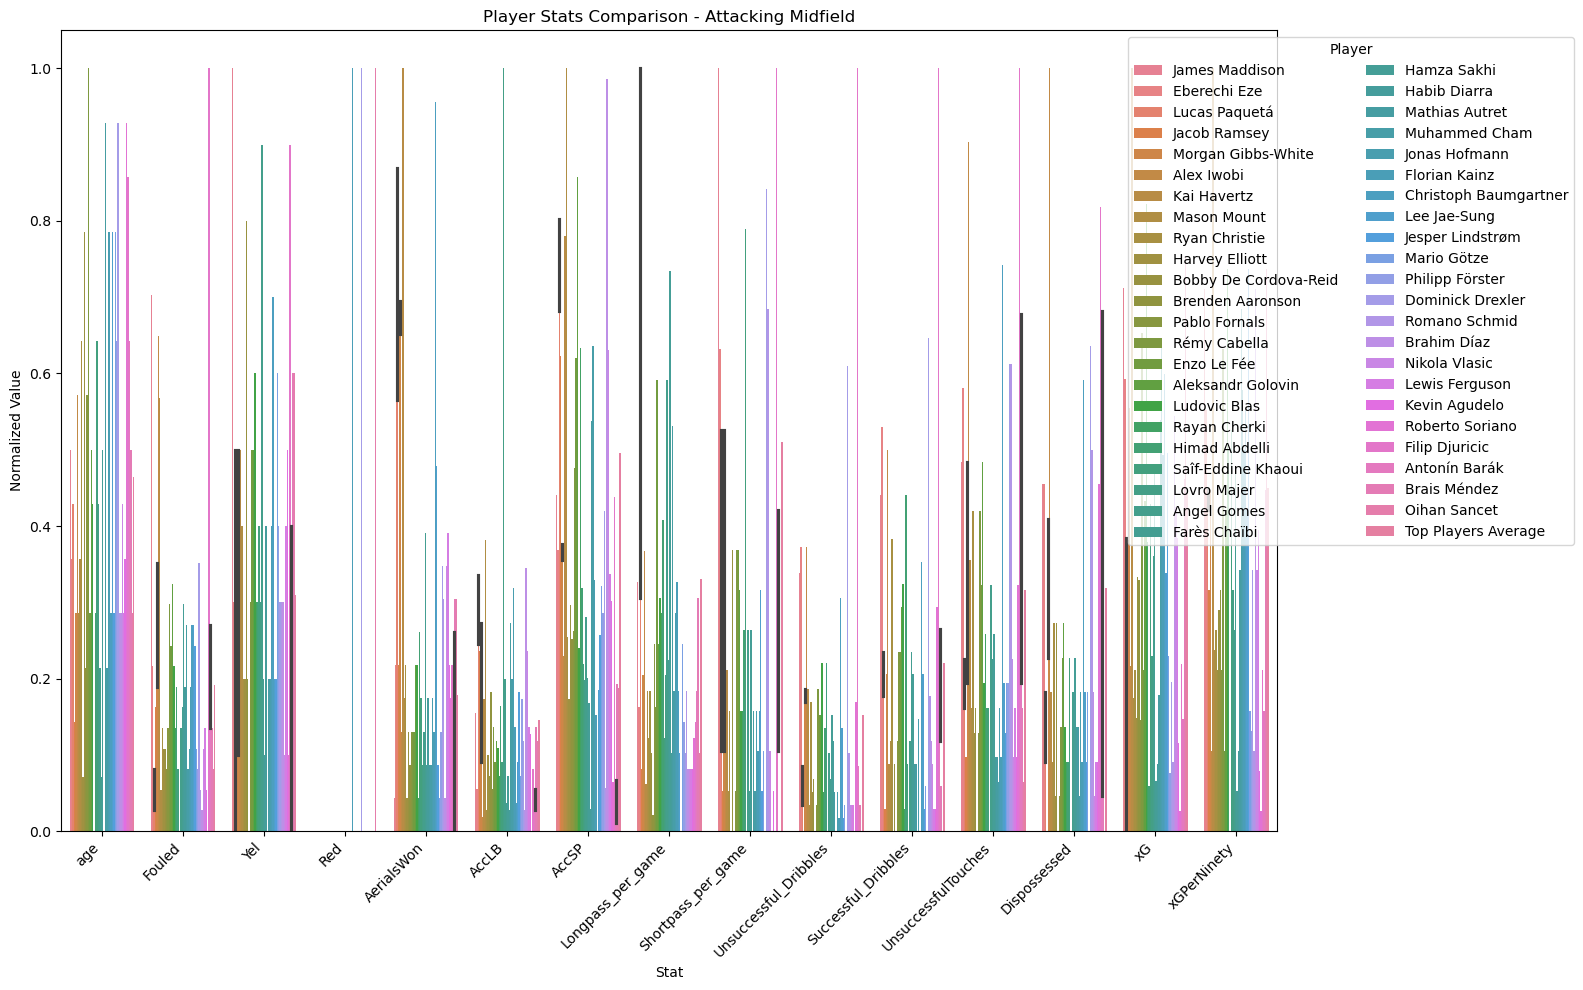

In [13]:
stat_columns = STATS_PER_POSITION[position]
top_players_avg_stats = top_players_stats_filtered[stat_columns].mean()
top_players_avg_stats = pd.DataFrame([top_players_avg_stats.values], columns=stat_columns)
top_players_avg_stats['player_name'] = 'Top Players Average'
combined_stats = pd.concat([similar_players_stats, top_players_avg_stats], ignore_index=True)

combined_stats = combined_stats.dropna(subset=stat_columns)

scaler = MinMaxScaler()
scaled_stats = scaler.fit_transform(combined_stats[stat_columns])
combined_stats[stat_columns] = scaled_stats

melted_stats = pd.melt(combined_stats, id_vars='player_name', value_vars=stat_columns, var_name='stat', value_name='value')
# melted_stats['stat'] = melted_stats['stat'].astype('category')

plt.figure(figsize=(16, 10))
player_order = melted_stats['player_name'].unique()
sns.barplot(x='stat', y='value', hue='player_name', data=melted_stats, hue_order=player_order)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Stat')
plt.ylabel('Normalized Value')
plt.title(f'Player Stats Comparison - {TARGET}')
plt.legend(title='Player', loc='upper right', bbox_to_anchor=(1.25, 1), ncol=2)
plt.tight_layout()
plt.show()